In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions,histfit
import fitter
import math
import random
from numpy import exp
import pyreadstat

from scipy.optimize import curve_fit

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results_mobility/'

# Datasets Reading

### MiD Data 2017
mobilität in deutschland

In [4]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('../data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2','W_ZWECK','ST_JAHR','ST_MONAT'])
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD.head(2)

,ST_MONAT,ST_JAHR,W_ZWECK,wegkm,hvm,hvm_diff2
0,3,2017,1,21.85,4,9
1,3,2017,5,0.39,1,1


In [5]:
# Different transport modes extraction
df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

### NHTS17 data
Travel behavior of the American public

trippub.csv:
data items collected for each trip made by each household member age 5+ on the household’s travel day (one record for each trip each person age 5+ made).

In [6]:
# data reading
# TRPMILES: Trip distance in miles, derived from route geometry returned
# TRPTRANS: Trip Mode, derived 
# WHYTRP1S: Trip purpose summary
df_Nhts=pd.read_csv('../data/trippub_2017NHTS.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])
df_Nhts.head(2)

,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1


In [7]:
# Different transport modes extraction and unit conversion to Km
# long distance public transport
#14City-to-city bus (Greyhound, Megabus), 19Airplane, 20Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  

# Modelling in long-distance public transport trips

### Error function

Calculating the error ( MSE or $error=\sum_{n=1}^{1000}\dfrac{|f(x_i)-g(x_i)|}{\dfrac{ f(x_i)+g(x_i)}{2}}$ ) between the function above and real data

In [8]:
''' Error function
Compute the distance between two 1D distributions.
Can be different length of these two distributions

d1,d2: the distribution, should be the type of List or pd.Series
'''

def custom_distance(d1,d2):
    if type(d1)==np.ndarray or type(d1)==list or type(d1)==pd.Series:
        if type(d2)==np.ndarray or type(d2)==list or type(d2)==pd.Series:
            # find the overlap of two distributions
            min_d=max(min(d1),min(d2))
            max_d=min(max(d1),max(d2))
        else:
            print('Wrong: Data type is not ndarray, List or pd.Series')
    else:
        print('Wrong: Data type is not ndarray, List or pd.Series')
    # re-sampling
    # given the point x value and whole data, calculate the point of y value in CCDF
    sorted_d1 = np.sort(d1)
    linspaced1 = np.linspace(0, 1, len(sorted_d1), endpoint=False)
    y_d1=1-linspaced1
    
    sorted_d2 = np.sort (d2)
    linspaced2 = np.linspace(0, 1, len(sorted_d2), endpoint=False)
    y_d2=1-linspaced2
    
    distance=0
    # number of linearly spaced numbers
    num=1000
    a = np.linspace(min_d,max_d,num)  
    
    for i in a:
        b1=np.interp(i, sorted_d1,y_d1)
        b2=np.interp(i, sorted_d2,y_d2)
        
        e=abs(b1-b2)/((b1+b2)/2)
        
        distance=distance+e
    return distance/num


## Fitting the amplified power-law to long distance data
#### Find and save the best parameters of the model to the original dataset

In [41]:
"""
Since there are two datasets MiD and NHTS, 
the comment about settings in this block relate to the conversion between these two datasets

Currently, it shows the perfomance on MiD dataset,
if you want to see another dataset, please uncomment them accordingly.
"""

# MiD long distance
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
# select the data trips between min and max distance to have a nicer observation
min_distance=100
max_distance=900
# used for Dynamic max distance
maxdistance=900

# # NHTS long distance
# df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS17
# # select the data trips between min and max distance to have a nicer observation
# min_distance=300
# max_distance=5000
# # used for Dynamic max distance
# maxdistance=5000

#number of trips to be generated for each parameter combination. high influence on calculation time!
sampleNumber_model=2000

df_vec=df_vec[df_vec.between(min_distance,max_distance)]

In [40]:
# definition/settings for datasets
# ----settings of parameters for MiD
eps_range=np.arange(0.9,1.8,0.02)
p_range=np.arange(0.7, 0.99, 0.01)
alp_range=np.arange(1.02,1.3,0.02)

# ----settings of parameters for NHTS
# eps_range=np.arange(0.8,1.8,0.01)
# p_range=np.arange(0.7,0.99, 0.01)
# alp_range=np.arange(1.02,1.6,0.05)

#error value
err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list


In [ ]:
%%time

''' Modelling to find the optimal parameters

In the model, it selects a number from geometric distribution instead of normal distribution

'''
tmp_max=(maxdistance/2) # a half of possible maximum distance
for i in range(len(combinable)):
    if i%100==0:
        print(i)
        print ("Current date and time : ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    eps=combinable[i][0]
    p=combinable[i][1]
    alp=combinable[i][2]
    error=combinable[i][3]
    all_dist=combinable[i][4]
    dist=[]
    for n in range(sampleNumber_model):
        distance=9999999
        '''Dynamic maximum distance
        idea---for long distance
        1. random select a start point in Germany
        2. compute the possible (roughly) max distance from the start point to the border
        
        - choose the direction uniformly, find the largest distance
        - choose the big cities (later...)
        
        think as ellipse
        '''
        #Dynamic maximum distance
        tmp=np.random.uniform(0,1) # (includes low, but excludes high)
        max_distance=math.sqrt(1-tmp)*tmp_max+tmp_max
        while(distance>=max_distance or distance<min_distance):
            # np.random.uniform(0,1,1) generates one uniform random number between 0 and 1.
            # let sp be drawn from pow(alpha)
            sp=np.random.uniform(0,1,1)**(-1/(alp-1))
            
            '''
            another approach
            '''
            ## alter: select a number (n) from geometric distribution like (1-p)
            # distance=((1+eps)^n)*distance
            distance=sp[0]
#             number=np.random.geometric(p,1)[0]
            number=np.random.geometric(1-p,1)[0]
            
            distance=((1+eps)**(number-1))*distance

        dist.append(distance)
      
    combinable[i][4]=dist
    # error computation
    error=custom_distance(dist,df_vec)
    combinable[i][3]=error


In [30]:
# Convert to dataframe and save
df_com=pd.DataFrame(combinable)
com=df_com.values

# The lowest error and corresponding parameters to get the optimal error
idx_best=com[:,3].argmin()
eps2 = com[idx_best,0]
p2 = com[idx_best,1]
alp2 = com[idx_best,2]
dist2= com[idx_best,4]

(36000, 5)


In [31]:
'''
Save only the best results to avoid excessive file storage requirements

Due to the random element in the modeling,
you can also find the stored results we used in the folder 'result_mobility'

Please uncomment the NHTS part when needed.

'''
# the results contain the value of eps,p, alpha errors and list of simulated trip length
opt_modelling=pd.DataFrame(combinable[idx_best])

opt_modelling.to_pickle(res+'Best results of LR Modelling in MiD17.pkl')
# save_best.to_pickle(res+'Best results of LR Modelling in NHTS17.pkl')

## Find and save the best parameters for truncated power-law fitting

- $f(d)=C*\dfrac{1}{d^{\alpha}} * e^{-\frac{d}{\gamma}}$

- $\sum_{d=100}^{900}f(d)=1$

- $C=\dfrac{1}{\sum_{d=100}^{900}\dfrac{1}{d^{\alpha}} * e^{-\frac{d}{\gamma}}}$

- $\alpha=1.02....1.2$, step=0.01

- $\gamma=200,250,300....600$, step=50

- $d=100,150...900$ step=50

- $\sum_{i=d}^{900}f(i)=F(d)$

- $\sum_{d=1}^{10^3} \dfrac{1}{d^{1.02}} * e^{\dfrac{-d}{600}}$

Compute C and plot F(d), f(x) is kind of pdf
Known: gamma (interval can be 10 or 50firstly), alpha, d(distance from 100 to 900 )

In [9]:
'''Normalize data before calculating errors to make differences more meaningful
since the data for error calculation may have large gaps regarding values itself, 
but we need to focus on the trend of dataset as well
''' 
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
'''
Caculate the distance/trips with or without C given
'''
def funcD(C,d,alpha,gamma):
    fD=C/d**alpha*(math.exp(-d/gamma))
    return fD
def funcD_noC(d,alpha,gamma):
    fD_noC=1/d**alpha*(math.exp(-d/gamma))
    return fD_noC

In [11]:
'''
MiD 2017
'''
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
min_distance=100
max_distance=2000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# limitations of searching the truncated power-law
alphas=np.arange(1.02, 1.051,0.005) 
gammas=np.arange(200, 1001,20)
Ds=np.arange(100,2001,1) #distance trips setted

In [53]:
'''
 NHTS 2017
 please uncomment when needed
'''
# df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS 2017
# min_distance=300
# max_distance=5000
# df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# # limitations of searching the truncated power-law
# alphas=[1.02,1.12]
# gammas=np.arange(400, 5001,50)
# Ds=np.arange(300,12001,10) #distance trips setted


In [12]:
%%time

'''
Finding optimal combination of parameters for truncated power law fitting
'''

results=[] # results contain alpha, gamma,C, error between the truncated power-law and emiprical data

for alpha in alphas:
    for gamma in gammas:
        # compute C
        temp=0
        for d in Ds:
            temp+=funcD_noC(d,alpha,gamma)
        C=1/temp
        
        #the distance
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        
        empircal_data=df_vec.tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        error=custom_distance(Fd,normalized_empircal)
        
        results.append([alpha,gamma,C,error])

CPU times: user 2min 44s, sys: 430 ms, total: 2min 45s
Wall time: 2min 45s


In [13]:
'''
Save the optimal truncated power-law fitting results
Please uncomment the NHTS part when needed
'''
#convert results to dataframe
results_truncated=pd.DataFrame(results, columns =['alpha', 'gamma', 'C','error']) 
# save the optimal results
opt_truncated=results_truncated.iloc[results_truncated.error.argmin(),:]
# MiD
opt_truncated.to_pickle(res+"Optimal truncated power-law in MiD.pkl")
# NHTS
# opt_truncated.to_pickle(res+"Optimal truncated power-law in NHTS.pkl")


# Comparing the optimal model and truncated power-law in long-distance public transport trips


### Regarding to MiD 2017

In [14]:
'''
 CCDF plots for MiD data
 normal=True means the CCDF is a normal CCDF plot, otherwise it will plot the CCDF with log-scale
'''
def custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True):
#     fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(3.54*2,2.83*2))
    colors=['#1f77b4','red']
    linestyles=['solid','dashdot']
    for i,data in enumerate(datalist):
        if i==0:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)
#         ax.plot(sorted_data, 1-linspaced,label=labels[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the final results
    for C,alpha,gamma in zip(Cs,alphas,gammas):
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        if gamma==gammas[0]:
            ax.plot(Ds,Fd,label='Truncated power-law best fit',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.8,linewidth=4)
        else:
            ax.plot(Ds,Fd,label='Truncated power-law γ=%d'%(gamma),color='#2ca02c',linestyle='dotted',rasterized=False,markersize=5,alpha=0.8,linewidth=4)

        empircal_data=datalist[0].tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        e=custom_distance(Fd,normalized_empircal)
    for i,data in enumerate(datalist):
        if i==1:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    if normal:
        leg = ax.legend(title='MiD Long Distance',loc='upper right',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=1e+3)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_MiD_LR_normal.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.yscale("log")
        plt.xscale("log")
        leg = ax.legend(title='MiD Long Distance',loc='lower left',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=1e+3)
        plt.ylim(bottom=1e-03)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_MiD_LR_log.pdf', dpi=100, bbox_inches='tight')    


In [15]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results_mobility"
'''
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
min_distance=100
max_distance=2000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR modelling in MiD17.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# Reading the stored optimal truncated power-law fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal truncated power-law in MiD.pkl')
# optimal alpha and gamma, handpicked alpha and gamma
alphas=[opt_trunc.alpha,1.02]
gammas=[opt_trunc.gamma,400]
Ds=np.arange(100,2001,1) #distance trips setted

CPU times: user 5.57 s, sys: 34.5 ms, total: 5.6 s
Wall time: 4.37 s


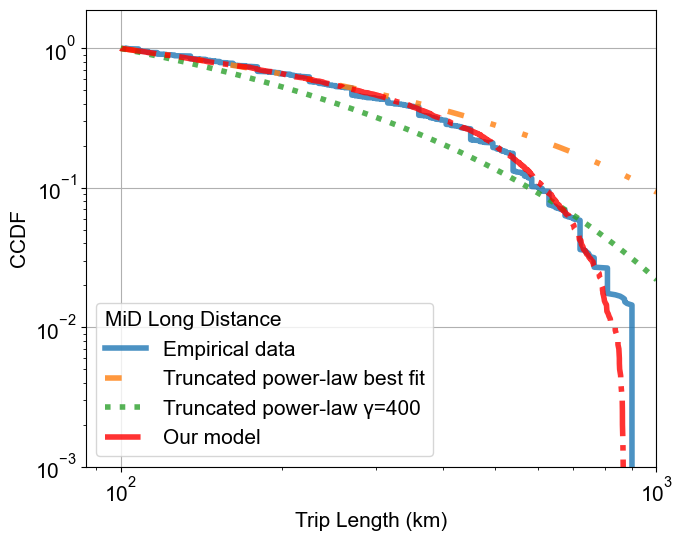

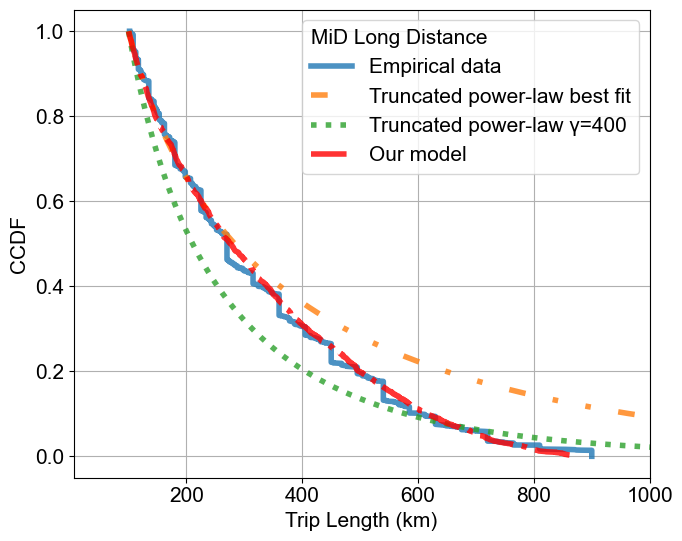

In [16]:
%%time
datalist=[df_vec,dist]
labels=['Empirical data','Our model']

Cs=[]
t=0
for alpha,gamma in zip(alphas,gammas):
    # compute C
    temp=0
    for d in Ds:
        temp+=funcD_noC(d,alpha,gamma)
    C=1/temp
    Cs.append(C)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=False)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True)

### Regarding to NHTS 2017

In [17]:
'''
 CCDF plots for NHTS data
 normal=True means the CCDF is a normal CCDF plot, otherwise it will plot the CCDF with log-scale
'''
def custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True):
#     fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(3.54*2,2.83*2))
    colors=['#1f77b4','red']
    linestyles=['solid','dashdot']
    for i,data in enumerate(datalist):
        if i==0:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)
#         ax.plot(sorted_data, 1-linspaced,label=labels[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the final results
    for C,alpha,gamma in zip(Cs,alphas,gammas):
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        if gamma==gammas[0]:
            ax.plot(Ds,Fd,label='Truncated power-law best fit',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.8,linewidth=4)
        else:
            ax.plot(Ds,Fd,label='Truncated power-law γ=%d'%(gamma),color='#2ca02c',linestyle='dotted',rasterized=False,markersize=5,alpha=0.8,linewidth=4)

        empircal_data=datalist[0].tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        e=custom_distance(Fd,normalized_empircal)
    for i,data in enumerate(datalist):
        if i==1:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    if normal:
        leg = ax.legend(title='NHTS Long Distance',loc='upper right',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=5e+3)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_NHTS_LR_normal.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.yscale("log")
        plt.xscale("log")
        leg = ax.legend(title='NHTS Long Distance',loc='lower left',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.ylim(bottom=1e-03)
        plt.xlim(right=5e+3) 
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_NHTS_LR_log.pdf', dpi=100, bbox_inches='tight')


In [18]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results_mobility"
'''
# NHTS dataset reading
df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS 2017
min_distance=300
max_distance=5000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR modelling in NHTS17.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# Reading the stored optimal truncated power-law fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal truncated power-law in NHTS.pkl')
# one parameter is optimal alpha and gamma, the other one is handpicked alpha and gamma
alphas=[opt_trunc.alpha,1.02]
gammas=[opt_trunc.gamma,1400]
Ds=np.arange(300,12001,10) #distance trips setted

CPU times: user 3.08 s, sys: 11.6 ms, total: 3.09 s
Wall time: 1.83 s


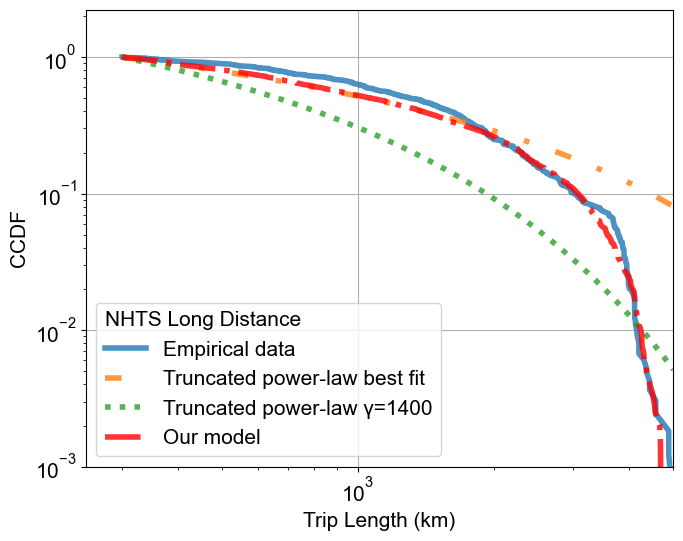

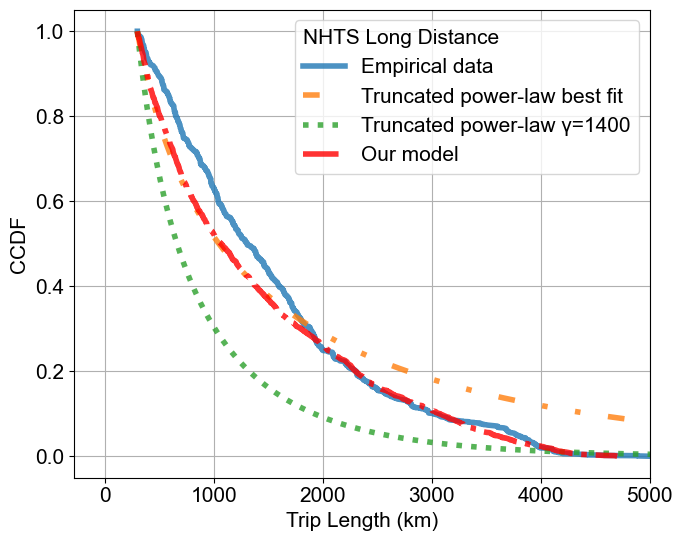

In [19]:
%%time
datalist=[df_vec,dist]
labels=['Empirical data','Our model']

Cs=[]
t=0
for alpha,gamma in zip(alphas,gammas):
    # compute C
    temp=0
    for d in Ds:
        temp+=funcD_noC(d,alpha,gamma)
    C=1/temp
    Cs.append(C)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=False)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True)